## Homography and Image Warping

<p style='direction:rtl; text-align: right'>
نقاط گوشه کتاب‌ها را به نقاط یک گوشه‌های مستطیل متناظر میکنیم. برای این منظور، ابتدا تخمینی از طول و عرض کتاب‌ها به دست می‌آوریم و سپس مستطیل‌هایی با آن ابعاد در نظر گرفته و نقاط گوشه کتاب‌ را با یک تبدیل هوموگرافی به نقاط مستطیل متناطر می‌کنیم.
</p>

<p style='direction:rtl; text-align: right'>
برای انجام تبدیل، به صورت برعکس عمل میکنیم و با ماتریس معکوس تبدیل، هر نقطه تصویر هدف را به تصویر اولیه میبریم و با تقریب bilinear مقدار پیکسل را به دست می‌آوریم و در تصویر هدف قرار می‌دهیم.
</p>

<p style='direction:rtl; text-align: right'>
ابتدا ایمپورت‌های لازم را انجام میدهیم و عکس‌‌ها را لود میکنیم.
</p>

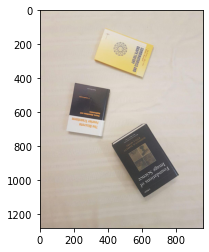

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

books = cv.imread('./data/books.jpg')

plt.imshow(cv.cvtColor(books, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
در تابع زیر، با استفاده از ماتریس درونیابی خطی، نقطه داده شده را در تصویر داده شده درونیابی می‌کنیم و بر میگردانیم.
</p>


In [2]:
def linear_interpolate(src, loc):
    loc_f = np.floor(loc).astype(int)
    x, y = loc
    x1, y1 = loc_f
    x2, y2 = x1 + 1, y1 + 1
    m1 = np.array([[x2 - x, x - x1]]).reshape(1, 2)
    m2 = np.array([[src[y1, x1], src[y2, x1]],
                   [src[y1, x2], src[y2, x2]]])
    m3 = np.array([y2 - y, y - y1]).reshape(2, 1)
    res = list()
    for k in range(src.shape[2]):
        try:
            a1 = np.matmul(m1, m2[:, :, k])
            a2 = np.matmul(a1, m3)
            res.append(a2)
        except ValueError as er:
            print(er)
            print(m1.shape, m2.shape, m3.shape)
    return np.clip(np.array(res), 0, 255)

<p style='direction:rtl; text-align: right'>
در تابع زیر، تبدیل تصویر با استفاده از ماتریس تبدیل هوموگرافی پیاده شده است. همانطور که گفته شد، هر پیکسل از تصویر هدف را در تصویر اصلی پیدا میکنیم و درونیابی می‌کنیم.
</p>


In [3]:
def warp_perspective(src, mat, dim):
    res = np.zeros(dim[::-1] + (3,))
    imat = np.linalg.inv(mat)
    for index in np.ndindex(*dim):
        tar_coord = np.array(index + (1,), dtype=float)
        src_coord = np.matmul(imat, tar_coord)
        src_coord /= src_coord[2]
        src_coord = src_coord[:2].astype(int)
        res[index[::-1]] = linear_interpolate(src, src_coord).reshape(3)
    return res.astype(np.uint8)

<p style='direction:rtl; text-align: right'>
مختصات کتاب‌ها در تصویر اصلی
</p>


In [4]:
b_coords = [  # coordinates of books in xy system. counter-clockwise order starting from top-left corner of the book
    np.array([[666, 207],
              [379, 104],
              [317, 284],
              [601, 389]]),
    np.array([[356, 738],
              [405, 463],
              [205, 424],
              [154, 706]]),
    np.array([[811, 968],
              [623, 668],
              [422, 794],
              [610, 1098]])]

<p style='direction:rtl; text-align: right'>
در نهایت، ابعاد کتاب‌ها را با میانگین گیری از فاصله جفت نقاط متناظر طول و عرض، به دست می‌آوریم.
تبدیل را برای ابعاد دو برابر انجام میدهیم تا مطمئن باشیم همه نقاط تصویر اصلی در تصویر نهایی حضور دارند. در نهایت با اعمال یک فیلتر گوسی و down sample با نرخ ۰.۵، آن‌ را به سایز تقریب زده شده می بریم.
</p>


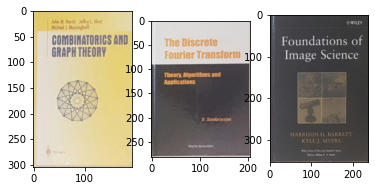

In [5]:
b_dims = [np.array([0.0, 0.0]) for i in range(3)]
mats = list()
imgs = list()

for b in range(3):
    for i in range(4):
        mag = b_coords[b][(i + 1) % 4] - b_coords[b][i]
        mag = np.linalg.norm(mag)
        b_dims[b][(i + 1) % 2] += mag
    b_dims[b] = b_dims[b].astype(np.int)
    mat, _ = cv.findHomography(b_coords[b],
                               np.array([[0, 0], [0, b_dims[b][1] - 1],
                                         [b_dims[b][0] - 1, b_dims[b][1] - 1], [b_dims[b][0] - 1, 0]]), cv.RANSAC, 5.0)
    mats.append(mat)
    img = warp_perspective(books, mat, tuple(b_dims[b]))
    img = cv.GaussianBlur(img, (3, 3), 0)
    img = cv.resize(img, (0, 0), img, 0.5, 0.5, cv.INTER_LINEAR)
    imgs.append(img)

fig, axs = plt.subplots(1,3)
for b, img in enumerate(imgs):
    axs[b].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
